In [1]:
# Download helper from google tutorial
from __future__ import print_function
import gzip
import os
import urllib

import numpy

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'


def maybe_download(filename, work_directory):
  """Download the data from Yann's website, unless it's already here."""
  if not os.path.exists(work_directory):
    os.mkdir(work_directory)
  filepath = os.path.join(work_directory, filename)
  if not os.path.exists(filepath):
    filepath, _ = urllib.urlretrieve(SOURCE_URL + filename, filepath)
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  return filepath


def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)


def extract_images(filename):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError(
          'Invalid magic number %d in MNIST image file: %s' %
          (magic, filename))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data


def dense_to_one_hot(labels_dense, num_classes=10):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


def extract_labels(filename, one_hot=False):
  """Extract the labels into a 1D uint8 numpy array [index]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError(
          'Invalid magic number %d in MNIST label file: %s' %
          (magic, filename))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    if one_hot:
      return dense_to_one_hot(labels)
    return labels


class DataSet(object):

  def __init__(self, images, labels, fake_data=False):
    if fake_data:
      self._num_examples = 10000
    else:
      assert images.shape[0] == labels.shape[0], (
          "images.shape: %s labels.shape: %s" % (images.shape,
                                                 labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      assert images.shape[3] == 1
      images = images.reshape(images.shape[0],
                              images.shape[1] * images.shape[2])
      # Convert from [0, 255] -> [0.0, 1.0].
      images = images.astype(numpy.float32)
      images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1.0 for _ in xrange(784)]
      fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir, fake_data=False, one_hot=False):
  class DataSets(object):
    pass
  data_sets = DataSets()

  if fake_data:
    data_sets.train = DataSet([], [], fake_data=True)
    data_sets.validation = DataSet([], [], fake_data=True)
    data_sets.test = DataSet([], [], fake_data=True)
    return data_sets

  TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
  TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
  TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
  TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
  VALIDATION_SIZE = 5000

  local_file = maybe_download(TRAIN_IMAGES, train_dir)
  train_images = extract_images(local_file)

  local_file = maybe_download(TRAIN_LABELS, train_dir)
  train_labels = extract_labels(local_file, one_hot=one_hot)

  local_file = maybe_download(TEST_IMAGES, train_dir)
  test_images = extract_images(local_file)

  local_file = maybe_download(TEST_LABELS, train_dir)
  test_labels = extract_labels(local_file, one_hot=one_hot)

  validation_images = train_images[:VALIDATION_SIZE]
  validation_labels = train_labels[:VALIDATION_SIZE]
  train_images = train_images[VALIDATION_SIZE:]
  train_labels = train_labels[VALIDATION_SIZE:]

  data_sets.train = DataSet(train_images, train_labels)
  data_sets.validation = DataSet(validation_images, validation_labels)
  data_sets.test = DataSet(test_images, test_labels)

  return data_sets

In [2]:
mnist = read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:43: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [3]:
mnist.test.images

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [4]:
mnist.test.images.shape

(10000, 784)

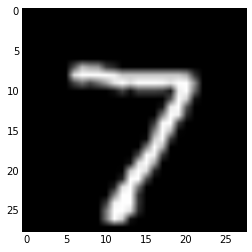

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(mnist.test.images[0].reshape([28,28]), cmap='gray')

In [6]:
from io import BytesIO
import cv2
import PIL
import numpy as np
from IPython.display import display, Image

def display_img_array(ima, **kwargs):
    if ima.dtype == np.float32 or ima.dtype == np.float64:
        ima = (ima*255).astype(np.uint8)
    im = PIL.Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png', **kwargs))
print(mnist.train.num_examples)
for i in range(10):
    print(mnist.train.labels[i])
    display_img_array(mnist.test.images[i].reshape([28,28]), width=200)

55000
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [ ]:
import tensorflow as tf
# Interactive session (aka default session)
sess = tf.InteractiveSession()

In [ ]:
from tfdot import tfdot

## Softmax regression

In [ ]:
x = tf.placeholder("float", shape=[None, 784], name="x")
y_ = tf.placeholder("float", shape=[None, 10], name="y_")

In [ ]:
W = tf.Variable(tf.zeros([784, 10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b')
tf.initialize_all_variables().run()

In [ ]:
tfdot()

In [ ]:
y = tf.nn.softmax(tf.matmul(x,W)+b, name="y_softmax")
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

In [ ]:
tfdot()

In [ ]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [ ]:
tfdot()

In [ ]:
for i in range(1000):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x:batch[0], y_:batch[1]})

In [ ]:
y.eval(feed_dict={x: mnist.test.images[:10]})

In [ ]:
prediction = tf.argmax(y, 1)

In [ ]:
# print predictions
prediction.eval(feed_dict={x: mnist.test.images[:10]})

In [ ]:
# print labels
np.argmax(mnist.test.labels[:10],1)

In [ ]:
display_img_array(mnist.test.images[8].reshape(28,28), width=100)

In [ ]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))

In [ ]:
correct_prediction.eval(feed_dict={x: mnist.test.images[:10] , y_: mnist.test.labels[:10]})

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [ ]:
accuracy.eval(feed_dict={x: mnist.test.images[:10] , y_: mnist.test.labels[:10]})

In [ ]:
accuracy.eval(feed_dict={x: mnist.test.images , y_: mnist.test.labels})

In [ ]:
for t in range(10):
    for i in range(1000):
        batch = mnist.train.next_batch(200)
        train_step.run(feed_dict={x:batch[0], y_:batch[1]})
    a = accuracy.eval(feed_dict={x: mnist.validation.images , y_: mnist.validation.labels})
    print (t, a)

In [ ]:
accuracy.eval(feed_dict={x: mnist.test.images , y_: mnist.test.labels})

 91% accuracy on MNIST is bad. It's almost embarrassingly bad.
 
 http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

# Multilayer Convolutional Network

In [1]:
# reset session and graph
import tensorflow as tf
from tfdot import tfdot
tf.ops.reset_default_graph()
if 'sess' in globals():
    sess.close()
sess = tf.InteractiveSession()
x = tf.placeholder("float", shape=[None, 784], name="x")
y_ = tf.placeholder("float", shape=[None, 10], name="y_")

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name ='W')
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = 'b')

In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [4]:
# fisrt layer
with tf.name_scope('conv1'):
    ## variables
    W_conv1 = weight_variable([5,5,1,32])
    b_conv1 = bias_variable([32])
    ## build the layer
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

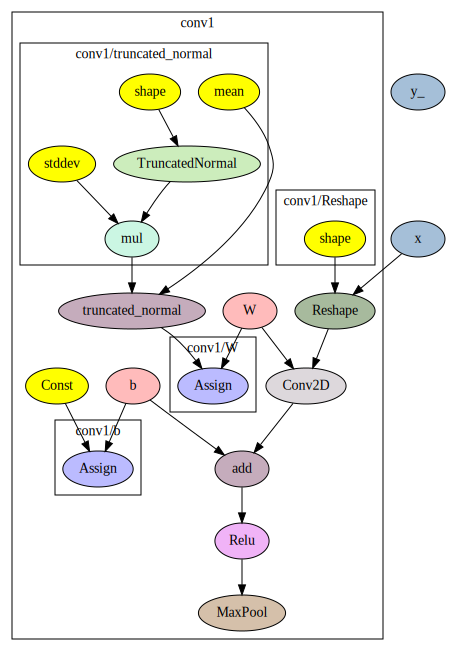

In [6]:
tfdot()

In [7]:
# second layer
with tf.name_scope('conv2'):
    ## variables
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])
    ## build the layer
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

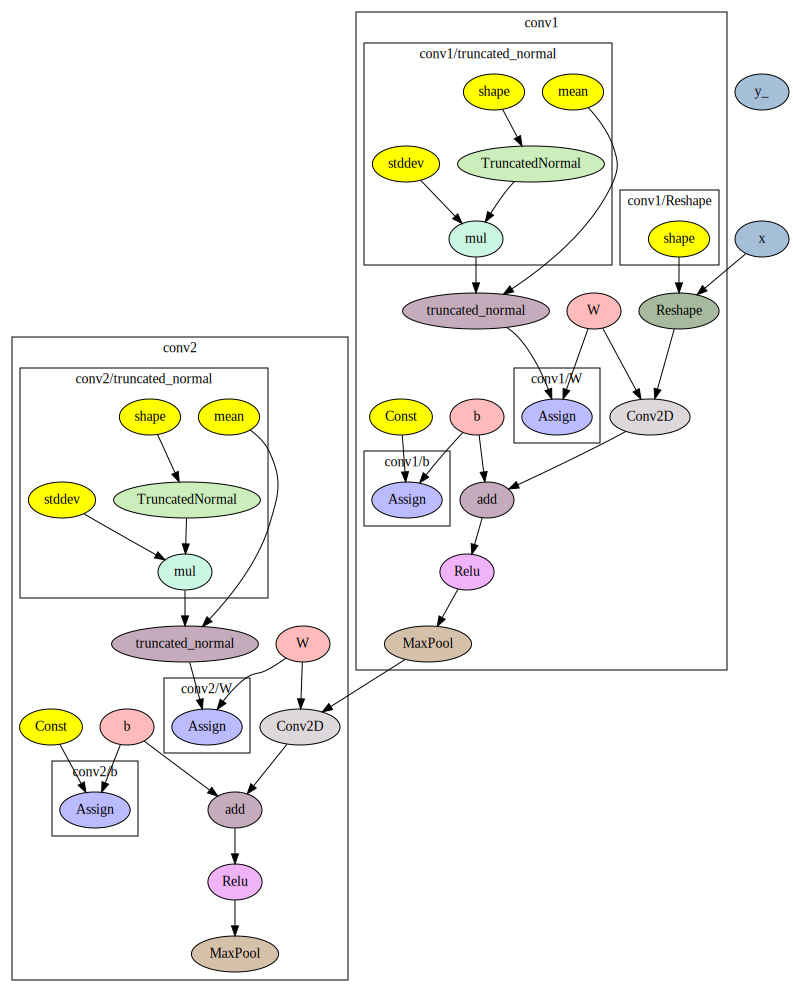

In [8]:
tfdot()

In [9]:
# fully-connected layer
with tf.name_scope('full'):
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1)+b_fc1)

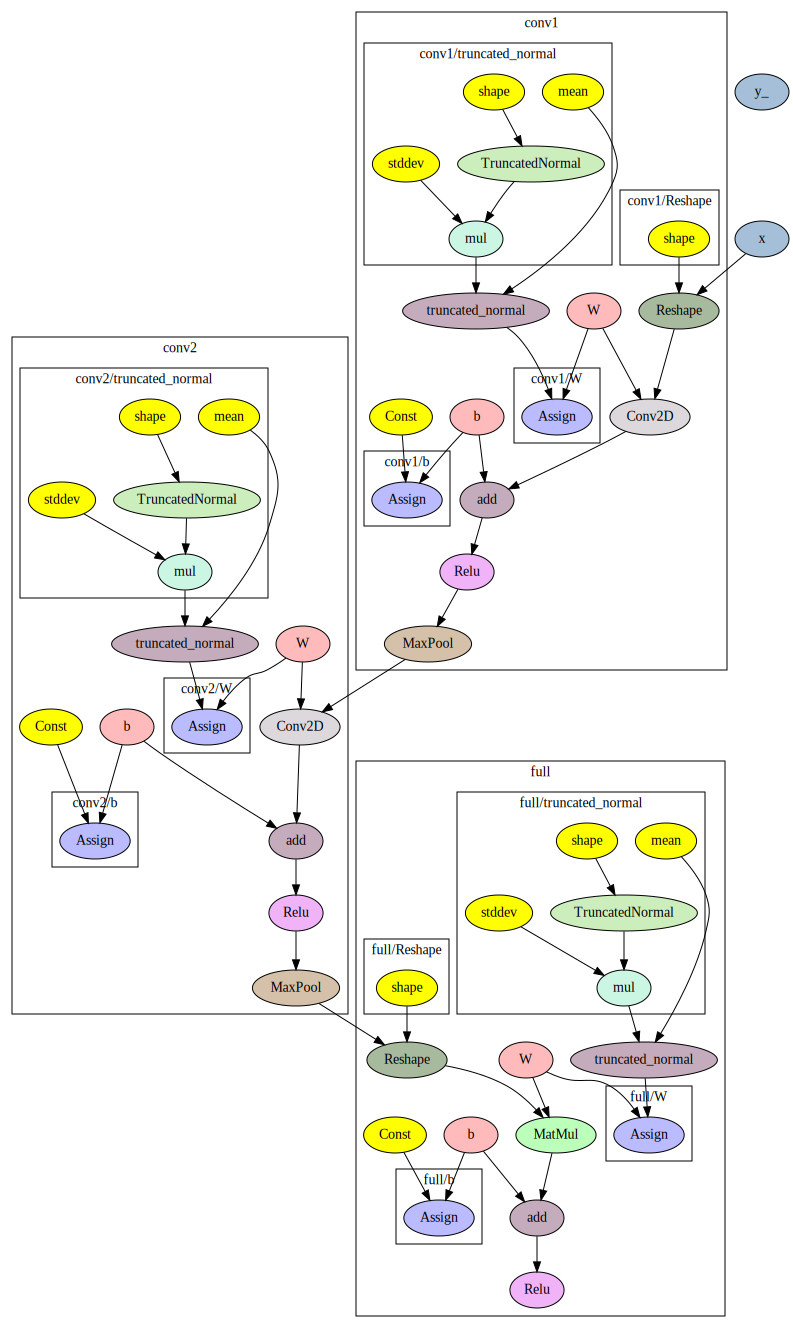

In [10]:
tfdot()

In [11]:
# Dropout:  A Simple Way to Prevent Neural Networks from Over fitting
# https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder("float")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [ ]:
# Readout
with tf.name_scope('readout'):
    W_fc2 = weight_variable([1024,10])
    b_fc2 = bias_variable([10])
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2)+b_fc2)

In [ ]:
cross_entropy = - tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
prediction = tf.argmax(y_conv, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [ ]:
%%timeit -r 1 -n 1
tf.initialize_all_variables().run()
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict = {
                x: batch[0], y_: batch[1], keep_prob: 1.0 })
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict= {x: batch[0], y_: batch[1], keep_prob: 0.5 })
for i in range(0, mnist.test.num_examples, 1000):
    print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[i:i+1000], 
                                                  y_: mnist.test.labels[i:i+1000],
                                                  keep_prob: 1.0}))

In [ ]:
np.mean([accuracy.eval(feed_dict={x: mnist.test.images[i:i+1000], 
                                   y_: mnist.test.labels[i:i+1000],
                                   keep_prob: 1.0}) 
        for i in range(0, mnist.test.num_examples, 1000)]
)

In [ ]:
tf.scalar_summary(accuracy.op.name, accuracy)
summary_op = tf.merge_all_summaries()
summary_writer = tf.train.SummaryWriter("log1", graph_def=sess.graph_def)

In [ ]:
%%timeit -r 1 -n 1
tf.initialize_all_variables().run()
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict = {
                x: batch[0], y_: batch[1], keep_prob: 1.0 })
        print("step %d, training accuracy %g"%(i, train_accuracy))
        summary_str = sess.run(summary_op, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0 })
        summary_writer.add_summary(summary_str, i)
    train_step.run(feed_dict= {x: batch[0], y_: batch[1], keep_prob: 0.5 })
for i in range(0, mnist.test.num_examples, 1000):
    print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[i:i+1000], 
                                                  y_: mnist.test.labels[i:i+1000],
                                                  keep_prob: 1.0}))

In [ ]:
np.mean([accuracy.eval(feed_dict={x: mnist.test.images[i:i+1000], 
                                   y_: mnist.test.labels[i:i+1000],
                                   keep_prob: 1.0}) 
        for i in range(0, mnist.test.num_examples, 1000)]
)